In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, accuracy_score, f1_score, roc_auc_score, r2_score

import torch
import xgboost as xgb

In [2]:
data_path = '../data/creditcard.csv'
plots_path = '../results/plots/'
results_path = '../results/'

# Ensure the results directories exist
os.makedirs(plots_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

In [3]:
def load_data(file_path):
    '''Load the dataset into a pandas DataFrame.'''
    return pd.read_csv(file_path)

In [4]:
def plot_fraud_amounts(df, output_path):
    '''Distribution of Fraud Transaction Amount.'''
    df_fraud = df[df['Class'] == 1]
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_fraud, x="Amount", bins=100, kde=True)
    plt.title('Fraud Transaction Amount Distribution')
    plt.xlabel("Fraud Amount (€)")
    plt.ylabel("Fraud Count")
    plt.show()
    plt.savefig(output_path)
    plt.close()

In [5]:
def plot_fraud_time(df, output_path):
    '''Distribution of Fraud Transaction Time.'''
    df_fraud = df[df['Class'] == 1]
    plt.figure(figsize=(10, 6))
    #sns.histplot(x=(df.loc[df["Class"] == 1,"Time"] // 3600) % 24, bins=24, kde=True)
    sns.histplot(x=(df_fraud["Time"] // 3600) % 24, bins=24, kde=True)
    plt.title('Fraud Transaction Time Distribution')
    plt.xlabel("Fraud Hours")
    plt.xticks(range(0, 24, 1))
    plt.ylabel("Fraud Count")
    plt.show()
    plt.savefig(output_path)
    plt.close()

In [6]:
def plot_correlation(df, output_path):
    '''Plot the correlation of the dataset features to the target variable.'''
    correlation = df.corr()['Class'].sort_values(ascending=False)[:10].drop('Class')
    #correlation.drop(["Class"]).plot(kind='bar')
    plt.figure(figsize=(10, 6))
    plt.title("Top 10 Features Most Correlated with Fraud")
    sns.barplot(x=correlation.values, y=correlation.index, palette="viridis")
    plt.ylabel("Feature")
    plt.xlabel("Correlation Coefficient")
    plt.tight_layout()
    plt.show()
    plt.savefig(output_path)
    plt.close()

In [7]:
def handle_class_imbalance(y_train):
    '''Handle class imbalance using undersampling.'''
    neg = np.sum(y_train == 0)
    pos = np.sum(y_train == 1)
    scale_pos_weight = neg / pos
    return scale_pos_weight

In [8]:
def scale_features(X_train, X_test):
    '''Scale the 'Amount' and 'Time' features using StandardScaler.'''
    ss = StandardScaler()
    X_train['Scaled_Amount'] = ss.fit_transform(X_train['Amount'].values.reshape(-1,1))
    X_train['Scaled_Time'] = ss.fit_transform(X_train['Time'].values.reshape(-1,1))

    X_test['Scaled_Amount'] = ss.transform(X_test['Amount'].values.reshape(-1,1))
    X_test['Scaled_Time'] = ss.transform(X_test['Time'].values.reshape(-1,1))
    
    X_train.drop(['Time', 'Amount'], axis=1, inplace=True)
    X_test.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    return X_train, X_test

In [19]:
def train_and_evaluate(X_train, X_test, y_train, y_test, scale_pos_weight):
    '''Train and evaluate an XGBoost model.'''
    def evaluate_model(y_test, y_score, threshold=0.5):
        y_pred = (np.array(y_score) >= threshold).astype(int)

        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
        print("Average Precision Score (PR-AUC):", average_precision_score(y_test, y_score))

        return average_precision_score(y_test, y_score)
    
    #X_np = X_train.to_numpy(dtype=np.float32, copy=False)
    #y_np = y_train.to_numpy(dtype=np.int8, copy=False)
    
    xgb_params = {
                    'booster': 'gbtree',
                    'subsample': 0.9966607688966372,
                    'colsample_bytree': 0.8378529488132844,
                    'lambda': 3.7012088448364884e-07,
                    'alpha': 8.516842169902498e-06,
                    'max_depth': 8,
                    'min_child_weight': 8,
                    'eta': 0.7767291260709535,
                    'gamma': 2.3072322802614006e-06,
                    'grow_policy': 'depthwise',
                    'objective': 'binary:logistic',
                    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
                    'verbosity': 2,
                    'eval_metric': 'aucpr',
                    'scale_pos_weight': scale_pos_weight, 
                    'seed': 42 
                }
    
    xgb_final = xgb.train(xgb_params, dtrain=xgb.DMatrix(X_train, label=y_train))
    y_score_final = xgb_final.predict(xgb.DMatrix(X_test))
    y_pred_label = (y_score_final >= 0.5).astype(int)
    
    # Write results to a text file
    with open(results_path + 'evaluation_results.txt', 'w') as f:
        f.write("XGBoost Classification Report:\n")
        f.write(classification_report(y_test, y_pred_label, digits=4))
        
        f.write("\nConfusion Matrix:\n")
        f.write(str(confusion_matrix(y_test, y_pred_label)))
        
        f.write("\nAccuracy: " + str(accuracy_score(y_test, y_pred_label)))
        f.write("\nF1 Score: " + str(f1_score(y_test, y_pred_label)))
        try:
            f.write("\nROC_AUC Score: " + str(roc_auc_score(y_test, y_score_final)))
            f.write("\nPR_AUC Score: " + str(average_precision_score(y_test, y_score_final)))
        except ValueError:
            pass
        

    
    return evaluate_model(y_test, y_score_final, threshold=0.5)
    
    

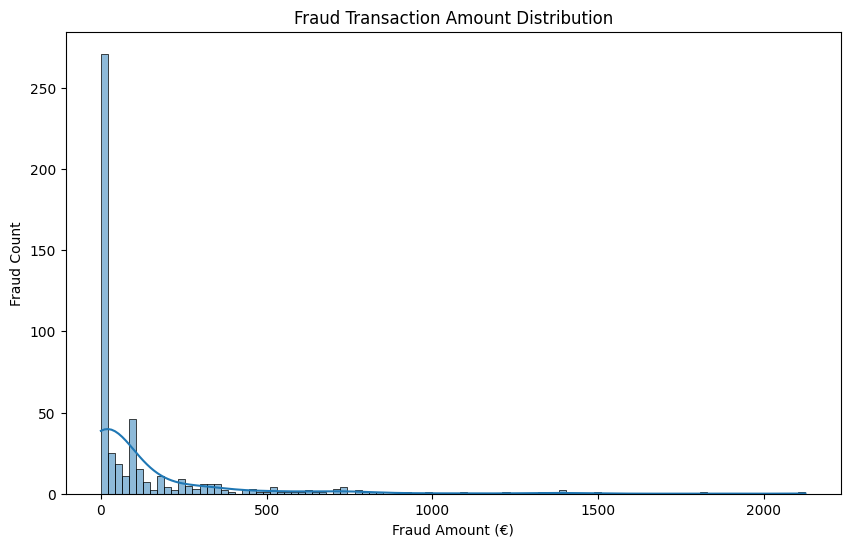

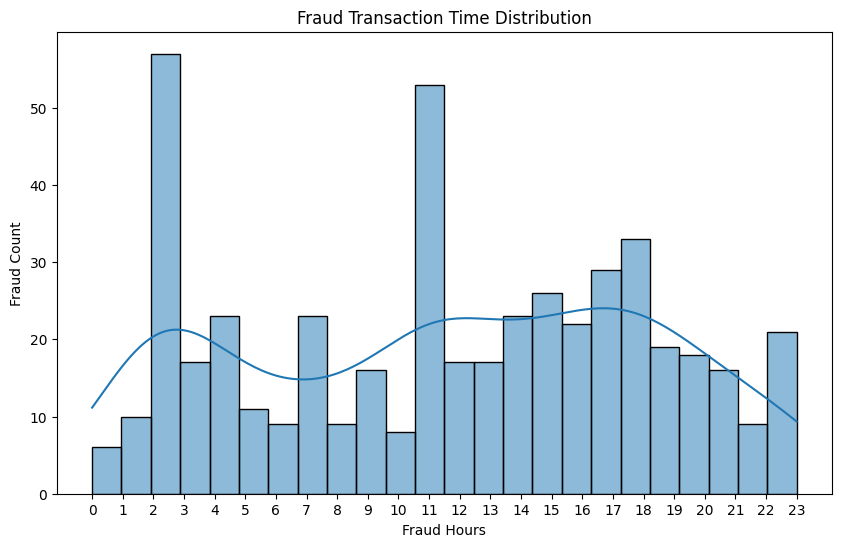

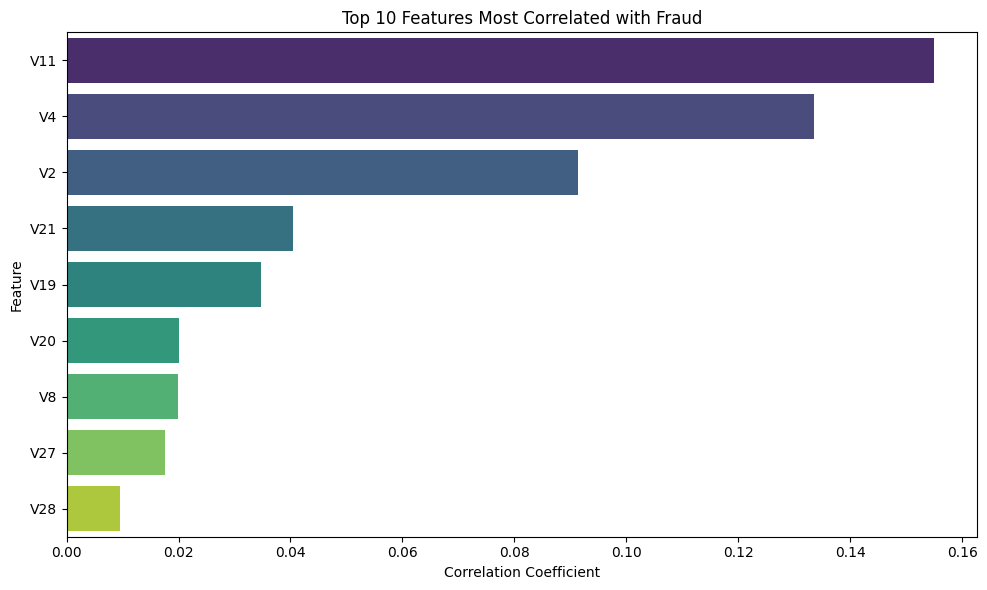

[07:02:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\simple_dmatrix.cc:149: Generating new Ellpack page.
[07:02:19] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\ellpack_page.cu:167: Ellpack is dense.
Confusion Matrix:
 [[56807    57]
 [   14    84]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9990    0.9994     56864
           1     0.5957    0.8571    0.7029        98

    accuracy                         0.9988     56962
   macro avg     0.7977    0.9281    0.8512     56962
weighted avg     0.9991    0.9988    0.9989     56962

Average Precision Score (PR-AUC): 0.8383453424643224
Average Precision Score: 0.8383


In [20]:
df = load_data(data_path)
plot_fraud_amounts(df, os.path.join(plots_path, 'fraud_amount.png'))
plot_fraud_time(df, os.path.join(plots_path, 'fraud_time.png'))
plot_correlation(df, os.path.join(plots_path, 'correlation_bar_plot.png'))

y = df['Class']
X = df.drop('Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scale_pos_weight = handle_class_imbalance(y_train)
X_train, X_test = scale_features(X_train, X_test)

avg_precision_score = train_and_evaluate(X_train, X_test, y_train, y_test, scale_pos_weight)
print(f'Average Precision Score: {avg_precision_score:.4f}')


    {
        'booster': 'gbtree',
        'subsample': 0.9966607688966372,
        'colsample_bytree': 0.8378529488132844,
        'lambda': 3.7012088448364884e-07,
        'alpha': 8.516842169902498e-06,
        'max_depth': 8,
        'min_child_weight': 8,
        'eta': 0.7767291260709535,
        'gamma': 2.3072322802614006e-06,
        'grow_policy': 'depthwise'
    }